#### 1.0 Setup

In [5]:
# pytorch
import torch
from torch import nn

# machine learning
import pandas as pd
import numpy as np

# scikit-learn (dataset)
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# file
from pathlib import Path
import requests

# visualization
import matplotlib.pyplot as plt

# device
device = "cpu"

# print(torch.__version__)
# print(np.__version__)

#### 2.0 Understand & Visualize Toy Dataset

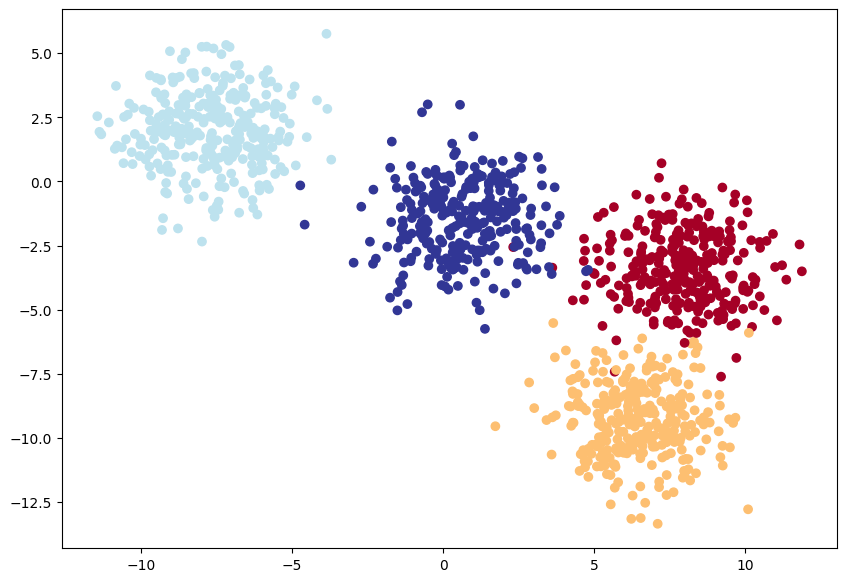

In [6]:
# 3D PLOT OF "MAKE_BLOBS" DATASET
"""
X, y = make_blobs(n_samples=1000, n_features=3, centers=4, cluster_std=1.5, random_state=11)

# Plot the dataset using matplotlib.pyplot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('make_blobs Synthetic Dataset')
plt.show()
"""

# set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2 # 2D Graph
RANDOM_SEED = 6

X_blob, y_blob = make_blobs(n_samples=1200,
                  n_features=NUM_FEATURES,
                  centers=NUM_CLASSES,
                  cluster_std=1.5,
                  random_state=RANDOM_SEED)

"""
X_blob_num = pd.DataFrame({"X1": X[:, 0],
                         "X2": X[:, 1],
                         "label": y})
print(X_blob_num.head(20))
"""

# convert data to tensors
X = torch.from_numpy(X_blob).type(torch.float)
y = torch.from_numpy(y_blob).type(torch.float)

# split data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

# plot data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)